In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
import numpy as np
import torch
import random
import scipy
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from collections import Counter
from collections import defaultdict
import math
import copy
import random
import pickle

In [2]:
make_dataset = False
noise = 1.5

In [7]:

file = 'Noise = 1.5'
if (file[0] == 'N'):
    df = pd.read_csv(file + '.csv')
    vals = []
    for row in df.iterrows():
      vals.append(row[1])
    vals = torch.Tensor(vals)
    vals = vals.squeeze(1)
    
else:
  df = pd.read_csv(file + '.csv')

  class Value(object):

      
      def __init__(self, date, val):
          self.date = date
          self.value = val
          
  unordered_time_series = defaultdict(float)


  for row in df.values:
      if (math.isnan(row[1]) == False ):
          
          last_date = row[1]
        
        
          unordered_time_series[row[0]] += row[1] 
  #     else:
  #       unordered_time_series[last_date] += row[2]




  # Separating the data by date

  time_series = []

  for key in unordered_time_series.keys():
      year = int(key.split('-')[0])
      month = int(key.split('-')[1])
      day = int(key.split('-')[2].split(' ')[0])
      hour = int(key.split(' ')[1].split(':')[0])
      date = datetime.date(year, month, day)
      time_series.append(Value(date, unordered_time_series[key]))
      
      
      
      
      
  # Sorting the data
  time_series.sort(key=lambda r: r.date)






  # Creating the data list

  vals = [] # list which contains the data
  days = []
  months = []
  weekdays = []
  value2index = defaultdict(int)
  index = 0
  for i in time_series:
      months.append(int(str(i.date).split(' ')[0].split('-')[1]))
      days.append(int(str(i.date).split(' ')[0].split('-')[1]))
      weekdays.append(int(i.date.weekday()))
      vals.append(i.value)
      
      value2index[i.value] = index
      index += 1
  vals_backup = vals
  print (len(vals))
  vals = torch.Tensor(vals)

In [8]:
# Rescaling the data and separating it in train/test/valid datasets
  
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))


      

test_proportion = 0.2
validation_proportion = 0.2

val_break = round(len(vals)*(1-(test_proportion + validation_proportion)))
test_break = round(len(vals)*(1-test_proportion))


values = vals[0 : val_break]
values_valid = vals[val_break : test_break]
values_test = vals[test_break:(len(vals))]
      
      
      
vals_normed = torch.Tensor(vals)
values = torch.Tensor(values)
values_test = torch.Tensor(values_test)
values_valid = torch.Tensor(values_valid)



max_vals = max(vals)

vals_normed = (vals_normed/max_vals + 1)/2 - 0.5 
values = values/max_vals
values_test = values_test/max_vals
values_valid = values_valid/max_vals


loss_fct = RMSELoss()

values_test = values_test.data.tolist()
values = values.data.tolist()
values_valid = values_valid.data.tolist()


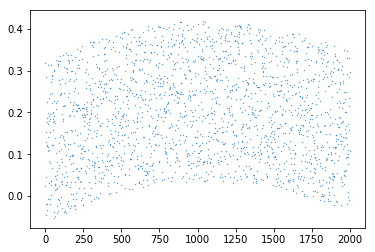

In [9]:
plt.scatter(range(vals.size(0))[:2000], vals_normed.data.tolist()[:2000], s = 0.1)
# plt.scatter(range(vals.size(0)), vals_normed.data.tolist(), s = 0.1)

In [10]:

gmm_range = (torch.Tensor(range(vals_normed.size(0))) - vals.size(0)/2)/vals.size(0)
gmm_data = np.array([[float(vals_normed[i]), float(gmm_range[i])] for i in range (gmm_range.size(0))])

gmm_batch_size = 800
gmm_interval = 50
number_gaussian_components = 4
Fisher_vector = []
with torch.no_grad():
  for i in range (0, len(gmm_data) - gmm_batch_size, gmm_interval):

    gmm = GaussianMixture(n_components = number_gaussian_components)
    gmm.fit(gmm_data[i : i+gmm_batch_size])
    u_k = np.zeros((4, 2))
    v_k = np.zeros((4, 2))
    cov_halfinvs = []

    # Calculating Sigma^{-1/2}
    for cov in gmm.covariances_:
      eigenval, eigenvec = scipy.linalg.eig(cov)
      inveigenval = [1/np.sqrt(float(i)) for i in eigenval]
      halfinv = np.dot(np.diag(inveigenval), np.transpose(eigenvec))
      cov_halfinvs.append(halfinv)
    current_fisher = []

    # Calculating u_k and v_k
    for component in range (number_gaussian_components):
      for j in range (i, i+gmm_batch_size):
        q_i = gmm.predict_proba(gmm_data[j].reshape(1,-1)).reshape(4)
        component_weight = gmm.weights_[component]

        u_k_term2 =  np.dot(cov_halfinvs[component] , 
                            (gmm_data[j]-gmm.means_[component]).reshape(2))
        u_k[component] +=  (q_i[component] / np.sqrt(gmm_batch_size * component_weight)) * u_k_term2


        v_k_term2 = np.array([i**2 for i in u_k_term2]) - 1    
        v_k[component] +=  q_i[component] * v_k_term2

      current_fisher.extend(u_k[component].reshape(2))
      current_fisher.extend(v_k[component].reshape(2))
    Fisher_vector.append(current_fisher)
    if (i%1000 == 0):
      print (i)

D:\python\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


0
1000


KeyboardInterrupt: 

In [ ]:
# The actual network
class WaveNet(nn.Module):
    def __init__(self, mu=1,n_residue=48, n_skip= 256, dilation_depth=10, 
                 n_repeat=5, nhpp = 50, nhpp_nbr = 0, additional_features = 0):
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        n_skip = int(np.ceil(n_skip/(dilation_depth*n_repeat))*(dilation_depth*n_repeat))
        self.nhpp_nbr = nhpp_nbr
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2**i for i in range(dilation_depth)] * n_repeat
#         self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=2, dilation=d)
                         for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_skip, kernel_size=1)
                         for d in dilations]) 
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue, out_channels=n_residue, kernel_size=1)
                         for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        
        if (additional_features > 0):      
          self.linear1 = nn.Linear(in_features= n_skip + nhpp_nbr + additional_features, out_features=mu) # + 3, i.e. month, day, weekday
        else:
          self.linear1 = nn.Linear(in_features= n_skip + nhpp_nbr, out_features=mu)
          
          
        if (nhpp_nbr + additional_features > 0): 
          self.linear_nhpp = nn.Linear(in_features = nhpp_nbr + additional_features, 
                                         out_features = nhpp_nbr + additional_features)
          
        self.dropout = nn.Dropout (p=0.5)
        
    def forward(self, input):
        # Separating histories
        history, nhpp = input
        
        
        
        wn_history = self.preprocess(history) # Preparing the history for the Wavenet sequence
        ######### Wavenet Sequence ##########
        
        skip_connections = []
        loop_cst = 0
        # Convolution sequence
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            wn_history, skip = self.residue_forward(wn_history, s, t, skip_scale, residue_scale)
            
            skip_connections.append(skip)
        # sum up skip connections
        wn_history = sum([s[:,:,-wn_history.size(2):] for s in skip_connections]) # If standard Wavenet
        ######## End of Wavenet Sequence #########
        # 
        output = self.postprocess(wn_history, nhpp)
        
        
        return output
    
    def preprocess(self, input):
        output = input.unsqueeze(0).unsqueeze(0).cuda()
        output = self.from_input(output)
        return output
    
    
    def postprocess(self, wn_history, nhpp):
        
        
            
        # Discard first nhpp (+1) points as we don't need them - they don't have nhpp history points
        wn_history = wn_history[:,:,-wn_history.size(2)+self.nhpp_nbr:]
        
        start_point = nhpp.size(1) - wn_history.size(2)
        
        nhpp = nhpp[:,start_point:].unsqueeze(0)
  
  
        # One layer to process the nhp
        if (add_nhpp_FF == True):
          if (nhpp.size(1) + additional_features > 0):
            nhpp = torch.tanh(self.linear_nhpp(nhpp.transpose(1,2)).transpose(1,2))
        
        output = torch.cat((wn_history, nhpp), dim = 1)
        
        
        output = output.transpose(1,2)

#         Dropout
        if (add_dropout == True):
          if (training_so_dropout == True):
            output = self.dropout(output)
      
        output = self.linear1(output).squeeze(0).squeeze(1) # Last layer: linear - for regression
        
        
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = torch.sigmoid(output_sigmoid) * torch.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    

In [ ]:
# Function which runs the algorithm


# classes = 128
# values = periodicise(classes, vals)
# vals = ground truth, all dataset
def run_algorithm_gpu(nhpp, n_residue, n_skip, dilation_depth, n_repeat,
                      max_epoch, batch_size, learn_rate, graph_cst, batches, additional_features = 0,
                      dbd_prediction = False, add_nhpp_FF = True, add_dropout = True):
    print ('nhpp', nhpp[nhpp_nbr].size(1))
    print ('additional features', additional_features)
    print ('n_residue', n_residue)
    print ('n_skip', n_skip)
    print ('dilation_depth', dilation_depth)
    print ('n_repeat', n_repeat)
    print ('max_epoch', max_epoch)
    print ('batch_size', batch_size)
    print ('learning rate', learn_rate)
    print ('add_nhpp_FF', add_nhpp_FF)
    print ('add_dropout', add_dropout)
    best_valid_epoch = 0
    net = WaveNet(mu=1,n_residue=n_residue,n_skip=n_skip,dilation_depth=dilation_depth,
                  n_repeat=n_repeat, nhpp = nhpp, nhpp_nbr = nhpp_nbr,
                 additional_features = additional_features).cuda()
    optimizer = optim.Adam(net.parameters(),lr=learn_rate)
#     optimizer = optim.Adam(net.parameters(),lr=learn_rate)
#     opti mizer = optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9)
    max_data = len(values)-batch_size
    
    
    loss_fct = RMSELoss()
    temp_loss = torch.Tensor(0)

    loss_save = [] 
    valid_loss_save = []
    valid_loss = 1000000
    last_loss = 1000000
    
    sequence_lowering_loss = 0
    
    for epoch in range(max_epoch):
        optimizer.zero_grad()
        loss = 0
        training_so_dropout = True
        for j in range(int(batches)):
            i = random.randint(0, len(values) - batch_size)
            batch = torch.FloatTensor(values[i : i + batch_size]).cuda()

            nhpp_sample = nhpp[nhpp_nbr][:,:, i : i + batch_size].cuda()
#             print (nhpp_sample.size())
            x = (batch[:-1], nhpp_sample[0,:,:-1])
            logits = net(x)
            sz = logits.size(0)
            temp_loss = loss_fct(logits, batch[-sz:])
            
            loss = loss + temp_loss
         
        loss = loss/batches
        loss.backward()
        optimizer.step()
        loss_save.append(float(loss))
        if (epoch % graph_cst == 0):
          training_so_dropout = False
      
          if (dbd_prediction == False):
#               print('-------test set, epoch {}--------'.format(epoch+1))
              batch = torch.FloatTensor(values_valid).cuda()
              nhpp_sample = nhpp_valid[nhpp_nbr]

              x = (batch[:-1], nhpp_sample[0,:,:-1])

              logits = net(x)
              l = logits 
              sz = logits.size(0)
              v_loss = loss_fct(logits, batch[-sz:])
#             t_loss = test_generation(nt = net, nhpp = nhpp[nhpp_nbr], plot=False, prediction_window = 5) # For maenners dataset
          else:    
            diff, t_loss = test_generation(nt = net, nhpp = nhpp_test[nhpp_nbr], plot=False, prediction_window = 30)
            
          if (v_loss < valid_loss):
            best_valid_epoch = epoch
            valid_loss = v_loss
            best_net = WaveNet(mu=1,n_residue=n_residue,n_skip=n_skip,dilation_depth=dilation_depth,
                                n_repeat=n_repeat, nhpp = nhpp, nhpp_nbr = nhpp_nbr,
                                additional_features = additional_features).cuda()
            best_net.load_state_dict(copy.deepcopy(net.state_dict()))
            
            valid_loss_save.append(float(valid_loss))
            
            
#           if(t_loss > last_loss):
#             sequence_lowering_loss += 1
#           else:
#             sequence_lowering_loss = 0
# #           print (sequence_lowering_loss, last_loss)
#           last_loss = t_loss
#           if(sequence_lowering_loss > 20):
#               print ('epoch finished', epoch)
#               break
            
            
    
            
#             print (t_loss, test_loss)
     
    return best_net, loss_save, valid_loss_save, best_valid_epoch

In [ ]:

# Function used to create the near history past points (nhpp for short)
def past_points_collector(values, gmm_batch_size):
  # Precomputing the allocation of each GMM's to each point and additional features
  # gmm_batch_size - starting point of allocation
  # every gmm_interval allocate the new batch of GMM's
  

  
  nhpp = torch.zeros([1,16,gmm_batch_size]).cuda()

  for i in range (gmm_batch_size + 1, len(values)):

    nhpp_temp = []

    nhpp_temp.extend(Fisher_vector[int(np.floor(i/gmm_interval))])
    nhpp_temp = torch.FloatTensor(nhpp_temp).unsqueeze(1).unsqueeze(0).cuda()
    nhpp = torch.cat((nhpp, nhpp_temp), dim = 2)

      
    
    
    
  return nhpp

In [ ]:
# Applying algorithm to the data, takes a long ass time

additional_features = 0
prediction_train_size = 100

import time


n_skips = [500]
# n_skips = [300, 700]


# learn_rates = [1e-3, 3e-3, 5e-3]
learn_rates = [1e-3]

# nhpp_nbrs = [0, 14, 28, 42, 56, 70, 84, 98] # tanke & tanke_ts & baerchen
nhpp_nbrs = [len(Fisher_vector[0])] # maenners

# nhpp_nbrs = [0, 42]


# dilation_depths = [6, 7] # tanke & tanke_ts & baerchen
dilation_depths = [12] # maenners
# dilation_depths = [6]

training_so_dropout = True
add_nhpp_FF = False
add_dropout = False





# Constants

number_of_experiments = 15 #constant saying how many experiments should be run for one setting of hyperparameters
# it's used to calculate the mean standard deviation of the test loss in the case we want to make a comparison with 
# other models



max_epoch = 1000
batches = 5
graph_cst = math.floor(max_epoch/50)
print ('graph cst', graph_cst)
n_residue = 25
n_repeat = 2







calc_length = len(nhpp_nbrs)*len(dilation_depths)*len(n_skips)*len(learn_rates) * number_of_experiments
calc_count = 0
dbd_prediction = False




net = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
nhpp = defaultdict(int)
nhpp_test = defaultdict(int)
nhpp_valid = defaultdict(int)
losses = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(
                                lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))))))


print (len(values))


for nhpp_nbr in nhpp_nbrs:
  for learn_rate in learn_rates:
    nhpp[nhpp_nbr] = past_points_collector(values = values, gmm_batch_size = nhpp_nbr)
    nhpp_test[nhpp_nbr] = past_points_collector(values_test, gmm_batch_size = nhpp_nbr)
    nhpp_valid[nhpp_nbr] = past_points_collector(values_valid, gmm_batch_size = nhpp_nbr)

    for n in range(len(n_skips)):
      
      n_skip = n_skips[n] - nhpp_nbr - additional_features

        #   for n_skip in n_skips:

      for dilation_depth in dilation_depths:
            batch_size = 2**(dilation_depth+1) + nhpp_nbr + prediction_train_size
            total_train_loss = torch.zeros(max_epoch)
            total_valid_loss = []
            best_valid_train_loss = []
            total_test_loss = []
    #     for nhpp_nbr in nhpps:


            for repeat in range (number_of_experiments):

              
              start = time.time()
              calc_count += 1


              net[nhpp_nbr][n_skip][dilation_depth][learn_rate], loss_save, valid_loss, best_valid_epoch = run_algorithm_gpu(nhpp = nhpp, 
                                                   n_residue = n_residue, 
                                                   n_skip = n_skip, 
                                                   dilation_depth = dilation_depth,  
                                                   n_repeat = n_repeat,
                                                   batch_size = batch_size, 
                                                   learn_rate = learn_rate, 
                                                   max_epoch = max_epoch,
                                                   graph_cst = graph_cst,
                                                   additional_features = additional_features,
                                                   dbd_prediction = dbd_prediction,
                                                   batches = batches,
                                                   add_nhpp_FF = add_nhpp_FF,
                                                   add_dropout = add_dropout)
          
              print ('best validation epoch', best_valid_epoch)
              
              
              # Calculating test loss
              batch = torch.FloatTensor(values_test).cuda()
              nhpp_sample = nhpp_test[nhpp_nbr]
              x = (batch[:-1], nhpp_sample[0,:,:-1])
              logits = net[nhpp_nbr][n_skip][dilation_depth][learn_rate](x)
              sz = logits.size(0)
              t_loss = loss_fct(logits, batch[-sz:])
              
              
              
          
              total_train_loss += torch.Tensor(loss_save)
              total_valid_loss.append(min(valid_loss))
              best_valid_train_loss.append(loss_save[best_valid_epoch])
              total_test_loss.append(float(t_loss))
              
              
              
              end = time.time()
              print ('---------------', 'done', (calc_count/calc_length) * 100, 
                    '% -----------------', 'time left', (end-start) * (calc_length-calc_count))
            
            
            total_train_loss = total_train_loss / number_of_experiments
            total_valid_loss = np.mean(total_valid_loss) 
            best_valid_train_loss = np.mean(best_valid_train_loss) 
#             total_test_loss = total_test_loss
            
            
            losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch] = [total_train_loss, 
                                                                                                                np.mean(total_valid_loss),
                                                                                                                np.mean(best_valid_train_loss),
                                                                                                                np.mean(total_test_loss),
                                                                                                                np.std(total_test_loss)]
            
              #         test_generation(first_points = 0, last_points = 60, prediction_window = 30)

In [ ]:
class l_class:
  def __init__(self):

        self.nhpp_nbr = 0

        self.n_residue  = 0

        self.n_skip  = 0

        self.n_repeat   = 0
        
        self.prediction_train_size = 0
        
        self.dilation_depth = 0
        
        self.learn_rate = 0
        
        self.max_epoch = 0
        
        self.loss_train = []
        self.loss_train_zero = []
        
        self.loss_valid = 0
        self.loss_valid_zero = 0
        
        self.loss_test = 0
        self.loss_test_zero = 0
        
        self.best_valid_train_loss = 0
        self.best_valid_train_loss_zero = 0
        
        self.test_std = 0
        
        self.nbr_of_experiments = 0

In [0]:
# Cell which saves the results for later analysis
# Showing the results and deciding which ones are good and which ones are not
# write_file_title = ""
if (make_dataset == True):
  write_file_title = "Fisher_" + "noise_"+str(noise)+"_results.txt"

else:
  write_file_title = "Autoencoder_Wavenet_"

  if (add_nhpp_FF == True):
    write_file_title = write_file_title + "FF_"
  if (add_dropout == True):
    write_file_title = write_file_title + "dropout_"
  write_file_title = write_file_title + "add_feat = " + str(additional_features) + "," + file + "_results.txt"
  
test_stds = []

f = open(write_file_title,"wb")
object_list = []

loss_fct = RMSELoss()
min_los = 10000
min_diff = 10000
los_list = []
for nhpp_nbr in losses.keys():
  for n_residue in losses[nhpp_nbr].keys():
    for n_skip in losses[nhpp_nbr][n_residue].keys():
      for dilation_depth in losses[nhpp_nbr][n_residue][n_skip].keys():
        for n_repeat in losses[nhpp_nbr][n_residue][n_skip][dilation_depth].keys():
          for prediction_train_size in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat].keys():
            for learn_rate in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size].keys():
              for max_epoch in losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate].keys():
                  if( type(losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch]) != int):
                    
                    # current results
                    los_train = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][0]
                    los_valid = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][1]
                    best_valid_train_loss = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][2]
                    test_los = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][3]
                    test_std = losses[nhpp_nbr][n_residue][n_skip][dilation_depth][n_repeat][prediction_train_size][learn_rate][max_epoch][4]

                    print ('test loss and test std', test_los, test_std)
                  

                    
  
                    # Writing to file
                    object_to_write = l_class()
                    
                    object_to_write.nhpp_nbr      = nhpp_nbr

                    object_to_write.n_residue       = n_residue

                    object_to_write.n_skip      = n_skip

                    object_to_write.n_repeat   = n_repeat

                    object_to_write.prediction_train_size = n_repeat

                    object_to_write.learn_rate = learn_rate
                    
                    object_to_write.dilation_depth = dilation_depth

                    object_to_write.max_epoch = max_epoch
                    
                    object_to_write.loss_train = los_train
                    
                    object_to_write.loss_valid = los_valid
                    
                    object_to_write.loss_test = test_los

                    object_to_write.best_valid_train_loss = best_valid_train_loss
                    
                    object_to_write.test_std = test_std
                    
                    object_to_write.nbr_of_experiments = number_of_experiments

                    object_to_write.total_time_duration = total_duration
                    
                    object_list.append(object_to_write)
                    
                    
pickle.dump(object_list, f)
f.close()

test_los and test_std_zero 0.34683617353439333 0.0012378922087593327


NameError: ignored

In [0]:
losses